# Uniswap fee choice analysis

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

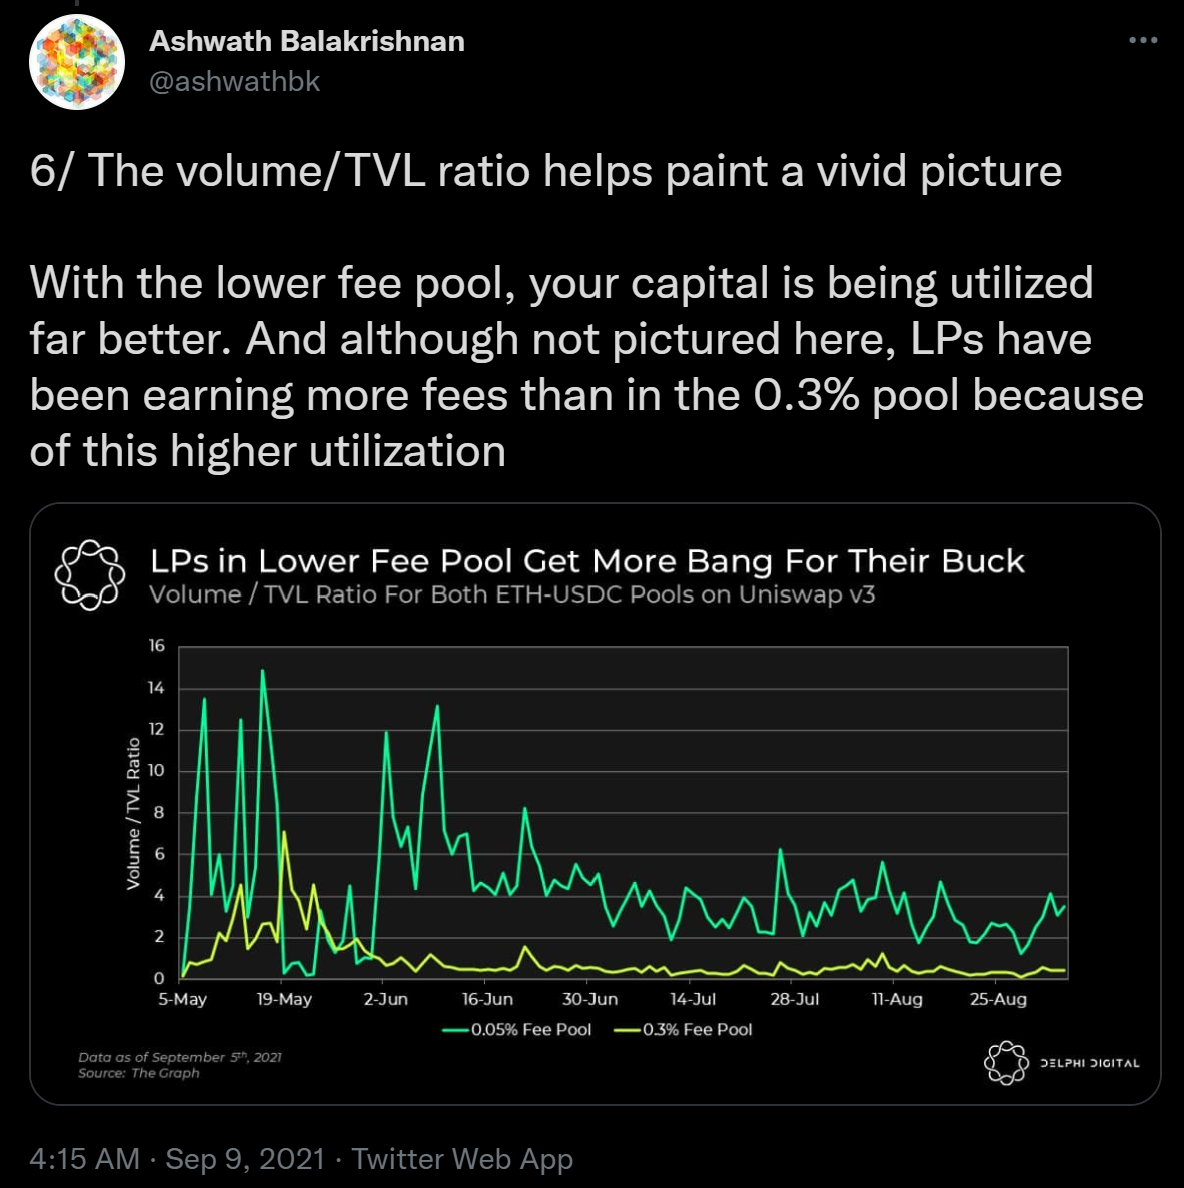

In [5]:
display(Image(filename = 'tweet.png', width = 400, height = 300))

## Let's take this analysis a step further
The tweet above failed to take into account the key feature of Uniswap V3: *Liquidity Concentration*

Let's analyse fee choice over time with the metric **Return per unit of (virtual) liquidity**

First: Let's look at virtual liquidity over time for the largest token-pair on V3: USDC-WETH

The data below looks at the active liquidity for each USDC-WETH pool (0.05%, 0.3%, 1%) on each day, as well as the fees collected on that day.

In [92]:
url = 'https://api.flipsidecrypto.com/api/v2/queries/ded2c07b-a8af-4d68-be80-be0348285c3f/data/latest'
x = requests.get(url)
df = pd.DataFrame(x.json())
df.sort_values(by = 'DAY', inplace = True)
df.reset_index(drop = True, inplace = True)
df.replace(np.nan, 0, inplace = True)
df['USD_FEES'] = df['TOKEN0_AVG_PRICE']*df['TOKEN0_FEES'] + df['TOKEN1_AVG_PRICE']*df['TOKEN1_FEES']
df.head()

,DAY,LIQUIDITY,POOL_ADDRESS,POOL_NAME,TOKEN0_AVG_PRICE,TOKEN0_FEES,TOKEN1_AVG_PRICE,TOKEN1_FEES,USD_FEES
0,2021-05-04T00:00:00Z,1.371680e+02,0x7bea39867e4169dbe237d55c8242a8f2fcdcc387,USDC-WETH 10000 200,0.999986,0.000000,3347.203726,0.000600,2.008322
1,2021-05-05T00:00:00Z,5.330467e+06,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC-WETH 3000 60,0.999990,3960.784020,3365.501053,0.835320,6772.011318
2,2021-05-05T00:00:00Z,1.361744e+04,0x7bea39867e4169dbe237d55c8242a8f2fcdcc387,USDC-WETH 10000 200,0.999990,77.677138,3365.501053,0.000349,78.850637
3,2021-05-05T00:00:00Z,3.913515e+04,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC-WETH 500 10,0.999990,0.432378,3365.501053,0.000403,1.788671
4,2021-05-06T00:00:00Z,9.733350e+05,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC-WETH 500 10,0.999901,454.037220,3487.829956,0.128207,901.156045


In [78]:
## defining a plot function to save time.
def liq_plot(df, variable, title, ylabel, x = 'DAY', kind = 'line', xlabel = 'Days since V3 release'):
    ax = df[df['POOL_NAME'] == 'USDC-WETH 3000 60'].plot(x = x, y = variable, kind = kind, label = '0.30', figsize = (12,8))
    df[df['POOL_NAME'] == 'USDC-WETH 500 10'].plot(x = x, y = variable, kind = kind, ax = ax, label = '0.05')
    df[df['POOL_NAME'] == 'USDC-WETH 10000 200'].plot(x = x, y = variable, kind = kind, ax = ax, label = '1.00')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

### Let's investigate the growth of liquidity across the three pools over time
As we can see in the chart below, liquidity has been very volatile, with the 0.05 pool slowly catching up to 0.3.

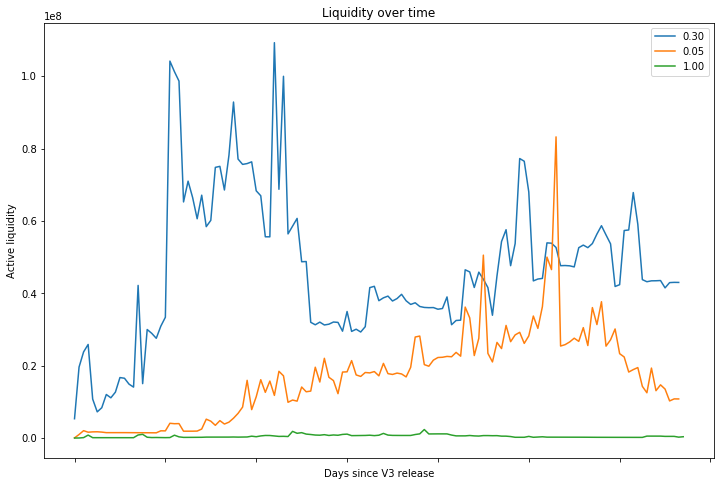

In [79]:
liq_plot(df, 'LIQUIDITY', 'Liquidity over time', 'Active liquidity')

### Now let's look at fees over time
As we can see, fees in the 0.3% pool have dominated the other pools since release of V3, but slowly the gap between 0.3 and 0.05 closes.

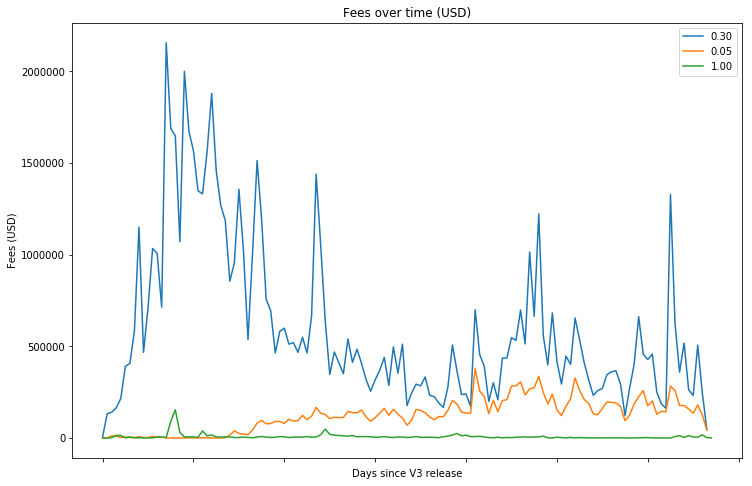

In [80]:
liq_plot(df, 'USD_FEES', 'Fees over time (USD)', 'Fees (USD)')

### Finally, let's look at our key metric; fees per unit of liquidity to get a true measure of the best pool

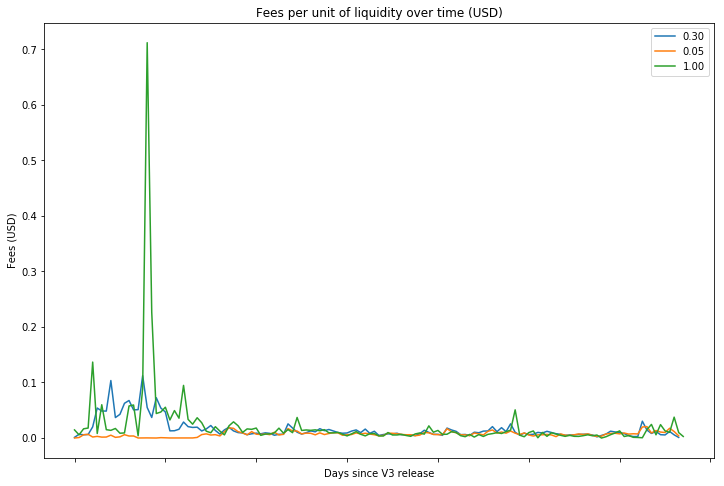

In [94]:
df['LIQUIDITY_ADJUSTED_FEES'] = df['USD_FEES'] /df['LIQUIDITY']
liq_plot(df, 'LIQUIDITY_ADJUSTED_FEES', 'Fees per unit of liquidity over time (USD)', 'Fees (USD)')

After a wild start, the difference is hard to spot. Let's zoom in a find out.

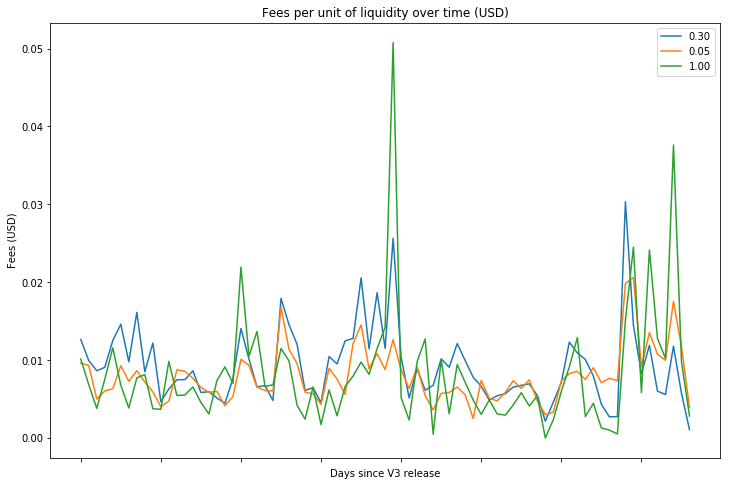

In [95]:
df_reduced = df[df['DAY'] > '2021-07-01']
liq_plot(df_reduced, 'LIQUIDITY_ADJUSTED_FEES', 'Fees per unit of liquidity over time (USD)', 'Fees (USD)')

Looking at the chart above, it appears there is no clear answer as to which pool is best. Adjusted returns are highly correlated as we can see spikes in the same places, overall it appears the variability is greatest in the 1% pool.

### So, which pool is best?
Let's look at a few different metrics over the last 30 days to get a clearer picture.

In [46]:
df_reduced = df[df['DAY'] > '2021-08-14']
x = df_reduced.pivot(index = 'DAY', columns = 'POOL_NAME', values = 'LIQUIDITY_ADJUSTED_FEES')
x.idxmax(axis = 1).value_counts()

USDC-WETH 500 10       14
USDC-WETH 3000 60      13
USDC-WETH 10000 200     6
dtype: int64

First - the number of days where each pool has the highest liquidity adjusted return.
Above, we can see the 0.05% pool just wins out with one extra day in front.

In [65]:
print(x.mean(), x.median(), x.min())

POOL_NAME
USDC-WETH 10000 200    0.007650
USDC-WETH 3000 60      0.008027
USDC-WETH 500 10       0.008048
dtype: float64 POOL_NAME
USDC-WETH 10000 200    0.004893
USDC-WETH 3000 60      0.006779
USDC-WETH 500 10       0.007361
dtype: float64 POOL_NAME
USDC-WETH 10000 200    0.000016
USDC-WETH 3000 60      0.001099
USDC-WETH 500 10       0.002529
dtype: float64


Second, the average/median liquidity adjusted return for each pool. Again, a close one with 0.05% winning on average, but a slightly larger margin on for the 50th percentile. This, with the minimums indicate a more consistent return can be achieved in the 0.05% pool.

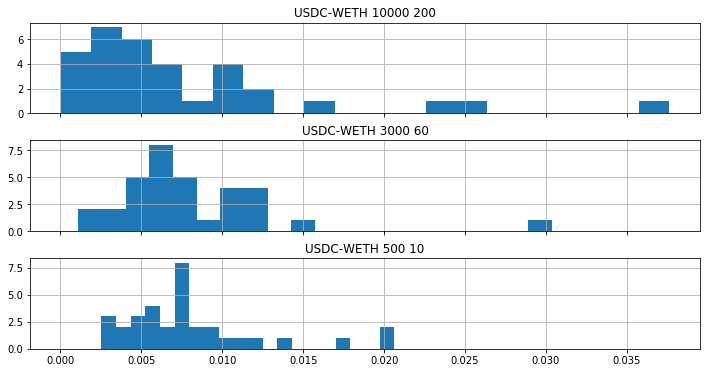

POOL_NAME
USDC-WETH 10000 200    0.008015
USDC-WETH 3000 60      0.005131
USDC-WETH 500 10       0.004403
dtype: float64

In [89]:
x.hist(sharex = True, figsize = (12,6), layout= (3,1), bins = 20)
plt.show()
x.std()

Finally, (excusing the bin width) we can see the spread of returns for 0.05 and 0.3 are roughly the same, indicating more consistent returns for your liquidity.

### Has this changed over time?
Let's take a look over different periods.

Text(0.5,0,'Days since V3 release')

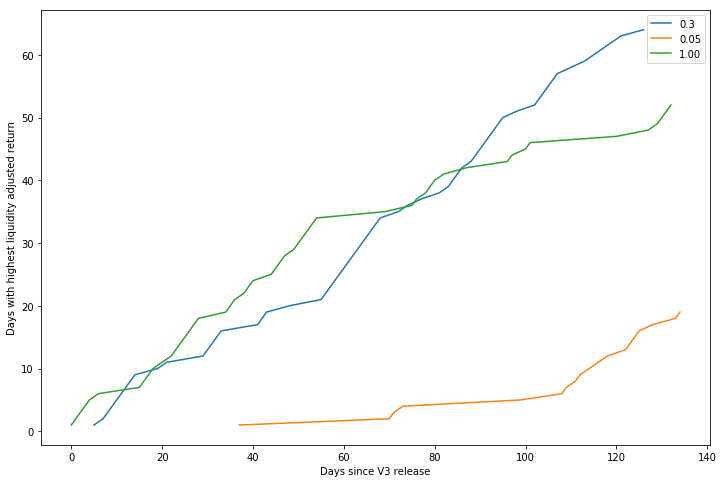

In [122]:
x = df.pivot(index = 'DAY', columns = 'POOL_NAME', values = 'LIQUIDITY_ADJUSTED_FEES')
x['max'] = x.idxmax(axis = 1)

x['run'] = x.groupby(x['max']).cumcount()+1
x.reset_index(inplace = True)
x.head(10)
ax = x[x['max'] == 'USDC-WETH 3000 60'].plot(use_index = True, y = 'run', kind = 'line', label = '0.3', figsize = (12,8))
x[x['max'] == 'USDC-WETH 500 10'].plot(use_index = True, y = 'run', kind = 'line', ax = ax, sharex = True, label = '0.05')
x[x['max'] == 'USDC-WETH 10000 200'].plot(use_index = True, y = 'run', kind = 'line', ax = ax, sharex = True, label = '1.00')
plt.ylabel('Days with highest liquidity adjusted return')
plt.xlabel('Days since V3 release')

The chart above shows the optimal pool has not been consistent over time. It started off with the 1% pool taking an early lead, then the 0.3% pool taking over. And finally, 0.05% has started shooting up, with 1% and 0.3% slowing down.

# Conclusion
In the case of Uniswap V3, liquidity adjusted returns are a more complete measure than fees/TVL.
In the analysis above we came to the same conclusion as the tweet, in the USDC-ETH pool the lowest fee pool has dominated in recent times across all measures.

But this has not always been the case, as V3 has matured (at least in the case of USDC-ETH) higher returns have gravitated towards the lowest fee pool. Will this continue to be the case into the future? Only time will tell.